In [ ]:
#all_slow

In [ ]:
# default_exp heusel2017gans

# GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium

Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). Gans trained by a two time-scale update rule converge to a local nash equilibrium. In Advances in neural information processing systems (pp. 6626-6637).

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from scipy import linalg
import torch
from torchvision.models.utils import load_state_dict_from_url
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.data.external import untar_data
from fastai.data.transforms import get_image_files
from fastai.data import *
from fastai.basics import *
from fastai.vision.all import *
from fastcore.all import *
from fastai.vision.gan import *
from fastpapers.core import *
import torch.nn.functional as F

In [ ]:
torch.cuda.set_device(3)

## The data

In [ ]:
path = download_file_from_google_drive(URLs.CELEBA, 'celebA.zip', folder_name='img_align_celeba')

In [ ]:
files = get_image_files(path.parent / 'img_align_celeba')

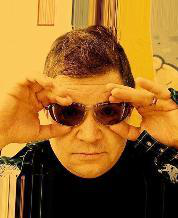

In [ ]:
PILImage.create(files[0])

## Fréchet Inception Distance (FID) 

The original implementation of the FID used the tensorflow weights of the [inceptionv3 from 2015-12-05](https://github.com/bioinf-jku/TTUR/blob/8eca1abd808aba8d8cf90208887453744bb53190/fid.py#L263), As noted by [hukkelas](https://github.com/hukkelas/pytorch-frechet-inception-distance).

In this implementation, by default, we use the pytorch/vision:v0.6.0 weights that produce different outputs. Nevertheless, the trends and the order of magnitud are the same. If you want, you can set `weight='old'` to use the original weights translated from TesnorFlow to PyTorch by [mseitzer](https://github.com/mseitzer/pytorch-fid).

In [ ]:
#export
class Inception:
    def __init__(self, weights='new', renormalize=False): 
        self.renorm_func = Normalize.from_stats(*renorm_stats) if renormalize else noop
        if weights=='new':
            model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
        elif weights=='old':
            model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=False, num_classes=1008)
            state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
            model.load_state_dict(state_dict, strict=False)
        model.eval();
        model.fc = Identity()
        model.dropout = Identity()
        self.model = model
    def __call__(self, x):
        with torch.no_grad():
            if min(x.shape[-2:])<299:
                x = F.interpolate(x, size=299)
            x = self.renorm_func(x)        
            return self.model(x)

In [ ]:
#export
class FIDMetric(Metric):
    def __init__(self, model, dl, get_prediction=noop):
        self.get_prediction = get_prediction
        self.func = model
        if dl.device.type == 'cuda':
            self.func.model.cuda()
        total = []
        for b in progress_bar(dl):
            if isinstance(b, tuple):
                if len(b)==2:
                    b = b[1]
            b = b[-1] if is_listy(b) else b
            total.append(self.func(b))
        total = torch.cat(total).cpu()
        self.dist_norm = total.mean(axis=0).pow(2).sum().sqrt()
        self.dist_mean = total.mean(axis=0)
        self.dist_cov = (total-self.dist_mean).T@(total-self.dist_mean)/total.shape[0]
    def reset(self): self.total, self.count = Tensor(), 0
    def accumulate(self, learn):
        if learn.model.gen_mode:
            pred =  learn.pred[-1] if is_listy(learn.pred) else learn.pred
            self.total = torch.cat([self.total, self.func(pred.detach()).cpu()])
            self.count += 1
    
    @property
    def value(self): 
        if self.count == 0: return None
        if self.total.is_cuda:
            warn('Accumulated values in FID are in cuda device.')
            self.total = self.total.cpu()
        self.sample_mean = self.total.mean(axis=0).cpu()
        self.sample_cov = (self.total-self.sample_mean).T@(self.total-self.sample_mean)/self.total.shape[0]
        self.sample_cov = self.sample_cov.cpu()
        mean_loss = nn.MSELoss(reduction='sum')(self.sample_mean, self.dist_mean)
        cov_sqrt = linalg.sqrtm(self.sample_cov@self.dist_cov)
        if np.iscomplexobj(cov_sqrt):
            if not np.allclose(np.diagonal(cov_sqrt).imag, 0, atol=1e-3):
                m = np.max(np.abs(cov_sqrt.imag))
                raise ValueError("Imaginary component {}".format(m))
            cov_sqrt = cov_sqrt.real
        tcov1 = np.trace(self.sample_cov)
        tcov2 = np.trace(self.dist_cov)
        tcov_sqrt = np.trace(cov_sqrt)
        cov_loss = tcov1+tcov2-2*tcov_sqrt
        return mean_loss + cov_loss
    
    @property
    def name(self): return 'FID'

In [ ]:
tfdl = TfmdLists(files[:1000], [PILImage.create, ToTensor])
dl = tfdl.dataloaders(after_batch=[Resize(64, method=ResizeMethod.Squish),
                                   IntToFloatTensor(),
                                   Normalize.from_stats(*imagenet_stats)])

inception = Inception(weights='old')
fid = FIDMetric(inception, dl.train)

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0
/home/andres/anaconda3/envs/fastai21/lib/python3.8/site-packages/torchvision/models/inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [ ]:
class GaussianNoise(DisplayedTransform):
    order = 11
    def __init__(self, alpha):
        self.alpha = alpha
    def encodes(self, x:(Image.Image, TensorImage)): 
        N = torch.randn(x.shape, device=x.device)
        N -= N.min()
        N /= N.max()
        return (1-self.alpha)*x+self.alpha*N
    def decodes(self, x): return x

In [ ]:
imgs = []
fids = []
noise_levels = master_bar([0, 0.25, 0.5, 0.75])
for noise in noise_levels:
    tfdl = TfmdLists(files[:10000], [PILImage.create, ToTensor])
    dl = tfdl.dataloaders(after_batch=[Resize(64, method=ResizeMethod.Squish),
                                       IntToFloatTensor(),
                                       GaussianNoise(noise),
                                       Normalize.from_stats(*imagenet_stats)],
                         shuffle_train=False)
    fid.reset()
    for b in progress_bar(dl.train, parent=noise_levels): fid.total = torch.cat([fid.total, fid.func(b).cpu()])
    fid.count = len(dl.train)
    fids.append(fid.value)
    imgs.append(TensorImage(dl.decode(dl.one_batch())[0]))

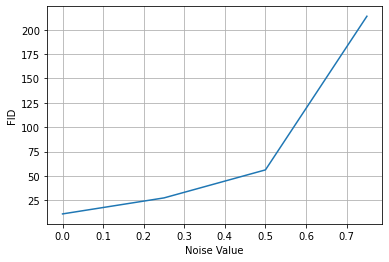

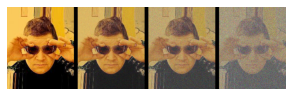

In [ ]:
plt.plot(list(noise_levels), fids)
plt.xlabel('Noise Value')
plt.ylabel('FID')
plt.grid(True)
ImageNTuple(imgs).show();

In [ ]:
class Blur(DisplayedTransform):
    order = 11
    def __init__(self, alpha):
        self.alpha = max(alpha, 1)
        padding = (self.alpha-1)//2
        self.conv = torch.nn.Conv2d(3, 3, self.alpha, groups=3, bias=False, padding=padding).cuda()
        torch.nn.init.constant_(self.conv.weight, 1/self.alpha**2)

    def encodes(self, x:(Image.Image, TensorImage)): return self.conv(x)

In [ ]:
imgs = []
fids = []
noise_levels = master_bar([0, 3, 5, 9])
for noise in noise_levels:
    tfdl = TfmdLists(files[:10000], [PILImage.create, ToTensor])
    dl = tfdl.dataloaders(after_batch=[Resize(299, method=ResizeMethod.Squish),
                                       IntToFloatTensor(),
                                       Blur(noise),
                                       Normalize.from_stats(*imagenet_stats)],
                         shuffle_train=False)
    fid.reset()
    for b in progress_bar(dl.train, parent=noise_levels):
        fid.total = torch.cat([fid.total, fid.func(b).cpu()])
    fid.count = len(dl.train)
    fids.append(fid.value)
    imgs.append(TensorImage(dl.decode(dl.one_batch())[0]))

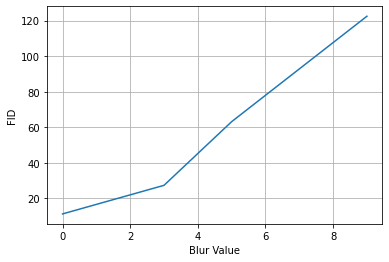

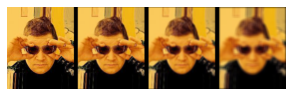

In [ ]:
plt.plot(list(noise_levels), fids)
plt.xlabel('Blur Value')
plt.ylabel('FID')
plt.grid(True)
ImageNTuple(imgs).show();

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted 02_heusel2017gans.ipynb.
Converted 03_johnson2016perceptual.ipynb.
Converted 04_carion2020end.ipynb.
Converted index.ipynb.
